### IMPLEMENTARE VAE_VGG (Variational Autoencoder cu o retea convolutionala VGG19) ###


In [20]:
import os
import sys
os.environ["KERAS_BACKEND"] = "tensorflow"
os.environ['XLA_FLAGS'] = '--xla_gpu_strict_conv_algorithm_picker=false'

import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import ops
from keras import layers


from PIL import Image
import matplotlib.pyplot as plt

from keras import utils, models
from keras.layers import Rescaling
from keras.applications.vgg19 import VGG19
from keras.applications.vgg19 import preprocess_input

In [21]:
print('keras: ', keras.__version__)
print('tensorflow: ',tf.__version__)
print('python: ',sys.version)
print(tf.version.GIT_VERSION, tf.version.VERSION)

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

keras:  3.6.0
tensorflow:  2.17.0
python:  3.10.13 | packaged by conda-forge | (main, Dec 23 2023, 15:36:39) [GCC 12.3.0]
unknown 2.17.0
Num GPUs Available:  3


In [ ]:
epochs = 50

# Set the environment variable to use only the first two GPUs
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1"

strategy = tf.distribute.MirroredStrategy()
print('Number of devices: {}'.format(strategy.num_replicas_in_sync))

BATCH_SIZE_PER_REPLICA = 128
BATCH_SIZE = BATCH_SIZE_PER_REPLICA * strategy.num_replicas_in_sync
BATCH_SIZE = 64
print(BATCH_SIZE)

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2')
Number of devices: 3
384


In [23]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a face."""

    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.seed_generator = keras.random.SeedGenerator(280602)

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = ops.shape(z_mean)[0]
        dim = ops.shape(z_mean)[1]
        epsilon = keras.random.normal(shape=(batch, dim), seed=self.seed_generator)
        return z_mean + ops.exp(0.5 * z_log_var) * epsilon

In [24]:
def create_encoder(input_shape=(128, 128, 3), latent_dim=256):
    inputs = keras.Input(shape=input_shape)
    
    
    x = layers.Conv2D(64, (4,4), activation='leaky_relu', strides=2, padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.2)(x)
    
    x = layers.Conv2D(128, (4,4), activation='leaky_relu', strides=2, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.2)(x)
    
    x = layers.Conv2D(256, (4,4), activation='leaky_relu', strides=2, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.2)(x)
    
    x = layers.Conv2D(512, (4,4), activation='leaky_relu', strides=2, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.2)(x)
    
    x = layers.Flatten()(x)
    
    # Add dense layers before final latent space
    x = layers.Dense(512, activation='leaky_relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.2)(x)
    
    z_mean = layers.Dense(latent_dim, name='z_mean')(x)
    z_log_var = layers.Dense(latent_dim, name='z_log_var')(x)
    z = Sampling()([z_mean, z_log_var])
    
    return keras.Model(inputs, [z_mean, z_log_var, z], name='improved_encoder')

In [25]:
def create_decoder(latent_dim=256):
    latent_inputs = keras.Input(shape=(latent_dim,))
    
    x = layers.Dense(8*8*512, activation='leaky_relu')(latent_inputs)
    x = layers.Reshape((8, 8, 512))(x)
    
    x = layers.Conv2DTranspose(256, (4,4), activation='leaky_relu', strides=2, padding='same')(x)
    x = layers.BatchNormalization()(x)
    
    x = layers.Conv2DTranspose(128, (4,4), activation='leaky_relu', strides=2, padding='same')(x)
    x = layers.BatchNormalization()(x)
    
    x = layers.Conv2DTranspose(64, (4,4), activation='leaky_relu', strides=2, padding='same')(x)
    x = layers.BatchNormalization()(x)
    
    x = layers.Conv2DTranspose(32, (4,4), activation='leaky_relu', strides=2, padding='same')(x)
    x = layers.BatchNormalization()(x)
    
    decoder_outputs = layers.Conv2DTranspose(3, (4,4), activation='sigmoid', padding='same')(x)
    
    return keras.Model(latent_inputs, decoder_outputs, name='improved_decoder')

In [26]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        
        # Initialize VGG19 for feature extraction (use pre-trained weights)
        vgg = VGG19(include_top=False, weights='imagenet', input_shape=(None, None, 3))
        
        # Choose intermediate layers for feature comparison
        self.feature_layers = [
            'block1_conv2',  # Low-level features
            'block2_conv2',  # Mid-level features
            'block3_conv2',  # Higher-level features
            'block4_conv2'   # Very high-level features
        ]
        
        # Create a model that outputs features from these layers
        self.feature_extractor = keras.Model(
            inputs=vgg.input, 
            outputs=[vgg.get_layer(name).output for name in self.feature_layers]
        )
        
        # Freeze the VGG19 weights
        self.feature_extractor.trainable = False
        
        # Tracking metrics
        self.total_loss_tracker = keras.metrics.Mean(name='total_loss')
        self.reconstruction_loss_tracker = keras.metrics.Mean(name='reconstruction_loss')
        self.perceptual_loss_tracker = keras.metrics.Mean(name='perceptual_loss')
        self.kl_loss_tracker = keras.metrics.Mean(name='kl_loss')
    
    def call(self, inputs):
        # Implement the forward pass
        z_mean, z_log_var, z = self.encoder(inputs)
        reconstruction = self.decoder(z)
        return reconstruction
    
    
    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.perceptual_loss_tracker,
            self.kl_loss_tracker 
        ]
    
    def compute_perceptual_loss(self, original, reconstructed):
        # Preprocess images for VGG19 (ensure 3 channels and correct scaling)
        original_processed = preprocess_input(original * 255.0)
        reconstructed_processed = preprocess_input(reconstructed * 255.0)
        
        # Extract features for original and reconstructed images
        original_features = self.feature_extractor(original_processed)
        reconstructed_features = self.feature_extractor(reconstructed_processed)
        
        # Compute perceptual loss as mean squared error between features
        perceptual_loss = 0
        for orig_feat, recon_feat in zip(original_features, reconstructed_features):
            perceptual_loss += ops.mean(ops.square(orig_feat - recon_feat))
        
        # Normalize by the number of feature layers
        perceptual_loss /= len(self.feature_layers)
        
        return perceptual_loss
    
    def compute_reconstruction_loss(self, original, reconstructed):
        
        reconstruction_loss = ops.mean(
                ops.sum(
                    keras.losses.binary_crossentropy(original, reconstructed),
                    axis=(1,2)
                )
            )
        
        return reconstruction_loss
   
    
    def train_step(self, data):
        with tf.GradientTape() as tape:
            # Encoder forward pass
            z_mean, z_log_var, z = self.encoder(data)
            
            # Decoder reconstruction
            reconstruction = self.decoder(z)
            
            # Compute KL divergence loss
            kl_loss = -0.5 * (1 + z_log_var - ops.square(z_mean) - ops.exp(z_log_var))
            kl_loss = ops.mean(ops.sum(kl_loss, axis=1))
            
            # Compute perceptual loss using VGG19 features
            perceptual_loss = self.compute_perceptual_loss(data, reconstruction)
            
            reconstruction_loss = self.compute_reconstruction_loss(data,reconstruction)
            
            # Total loss combines perceptual loss and KL divergence
            total_loss = perceptual_loss + kl_loss + reconstruction_loss
        
        # Compute gradients and apply them
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        
        # Update metrics
        self.total_loss_tracker.update_state(total_loss)
        self.perceptual_loss_tracker.update_state(perceptual_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        
        return {
            "loss": self.total_loss_tracker.result(),
            "perceptual_loss": self.perceptual_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
            "recreation_loss": self.reconstruction_loss_tracker.result()
        }

In [27]:
train_data = utils.image_dataset_from_directory(
    './Dataset/train',
    labels=None,
    label_mode='categorical',
    batch_size=None,
    image_size=(128, 128),
    shuffle=True,
    seed=123,
    interpolation='bilinear',
)

# Normalize the images by dividing by 255.0
normalization_layer = Rescaling(1./255)
train_data = train_data.map(lambda x: normalization_layer(x))

train_data = train_data.batch(BATCH_SIZE,drop_remainder=True)

Found 192469 files.


In [ ]:
# with strategy.scope():
    # Updated training setup
latent_dim = 512  # Increased latent dimension

# Create improved models
encoder = create_encoder(latent_dim=latent_dim)
decoder = create_decoder(latent_dim=latent_dim)

# Compile with better optimizer
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-4))

# vae.encoder.summary()
# vae.decoder.summary()
# vae.summary()

load = False

if load == True:
    vae.load_weights('results_encode_decode/1/vae_weights.weights.h5')
else:
    vae.fit(train_data, epochs=epochs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 800ms/step


W0000 00:00:1734263007.769513 1913366 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Conv2D" attr { key: "T" value { type: DT_FLOAT } } attr { key: "data_format" value { s: "NHWC" } } attr { key: "dilations" value { list { i: 1 i: 1 i: 1 i: 1 } } } attr { key: "explicit_paddings" value { list { } } } attr { key: "padding" value { s: "SAME" } } attr { key: "strides" value { list { i: 1 i: 2 i: 2 i: 1 } } } attr { key: "use_cudnn_on_gpu" value { b: true } } inputs { dtype: DT_FLOAT shape { dim { } dim { size: 128 } dim { size: 128 } dim { size: 3 } } } inputs { dtype: DT_FLOAT shape { dim { size: 4 } dim { size: 4 } dim { size: 3 } dim { size: 64 } } } device { type: "GPU" vendor: "NVIDIA" model: "NVIDIA A40" frequency: 1740 num_cores: 84 environment { key: "architecture" value: "8.6" } environment { key: "cuda" value: "12000" } environment { key: "cudnn" value: "90300" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 6291456 shared_memory_size_per_mult

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 650ms/step


W0000 00:00:1734263008.519639 1913366 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Conv2DBackpropInput" attr { key: "T" value { type: DT_FLOAT } } attr { key: "data_format" value { s: "NCHW" } } attr { key: "dilations" value { list { i: 1 i: 1 i: 1 i: 1 } } } attr { key: "explicit_paddings" value { list { } } } attr { key: "padding" value { s: "SAME" } } attr { key: "strides" value { list { i: 1 i: 1 i: 2 i: 2 } } } attr { key: "use_cudnn_on_gpu" value { b: true } } inputs { dtype: DT_INT32 shape { dim { size: 4 } } } inputs { dtype: DT_FLOAT shape { dim { size: 4 } dim { size: 4 } dim { size: 256 } dim { size: 512 } } } inputs { dtype: DT_FLOAT shape { dim { } dim { size: 512 } dim { size: 8 } dim { size: 8 } } } device { type: "GPU" vendor: "NVIDIA" model: "NVIDIA A40" frequency: 1740 num_cores: 84 environment { key: "architecture" value: "8.6" } environment { key: "cuda" value: "12000" } environment { key: "cudnn" value: "90300" } num_registers: 65536 l1_c

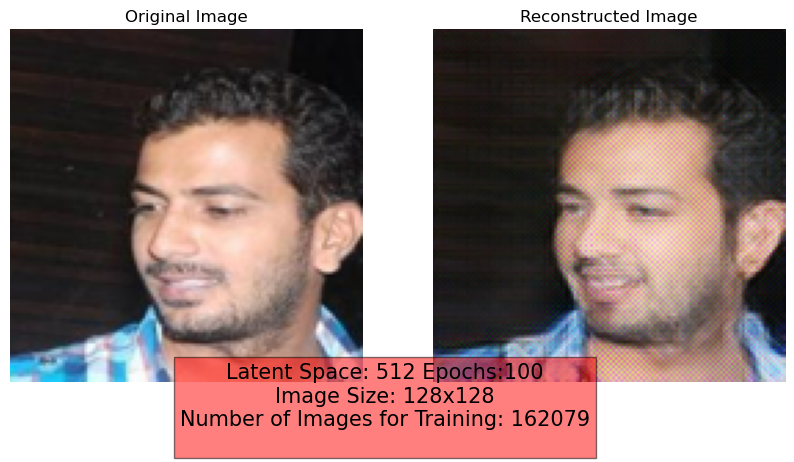

In [ ]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

height = 128
width = 128
no_images = 162079
test_image_dir = './Dataset/test'
test_image_name = '000206.jpg'

img = Image.open(os.path.join(test_image_dir, test_image_name))
img = img.resize((height, width))
img = np.array(img)
img = img.astype('float32') / 255.


z_mean, z_log_var, z = encoder.predict(np.expand_dims(img, axis=0))

reconstructed_img = decoder.predict(z)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))


axes[0].imshow(img)
axes[0].set_title('Original Image')
axes[0].axis('off')

axes[1].imshow(reconstructed_img[0])
axes[1].set_title('Reconstructed Image')
axes[1].axis('off')



# Add information about the run to the plot
info_text = f"Latent Space: {latent_dim} Epochs:{epochs}\nImage Size: {height}x{width}\nNumber of Images for Training: {no_images}\n"
fig.text(0.5, 0.01, info_text, ha='center',fontsize=15, bbox=dict(facecolor='red', alpha=0.5))

SAVE = True
if SAVE:
    # Save the plot as a JPG file in the specified folder
    output_dir = 'results_encode_decode'
    os.makedirs(output_dir, exist_ok=True)
    result_counter_path = os.path.join(output_dir, 'result_counter.txt')

    if os.path.exists(result_counter_path):
        with open(result_counter_path, 'r') as file:
            result_no = int(file.read().strip()) + 1
    else:
        result_no = 0

    with open(result_counter_path, 'w') as file:
        file.write(str(result_no))

    result_dir = os.path.join(output_dir, str(result_no))
    os.makedirs(result_dir, exist_ok=True)

    # Save weights in result dir
    vae.save_weights(os.path.join(result_dir, 'vae_weights.weights.h5'))
    vae.encoder.save_weights(os.path.join(result_dir, 'encoder_weights.weights.h5'))
    vae.decoder.save_weights(os.path.join(result_dir, 'decoder_weights.weights.h5'))

    output_path = os.path.join(result_dir, 'result.jpg')
    plt.savefig(output_path, format='jpg')

plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


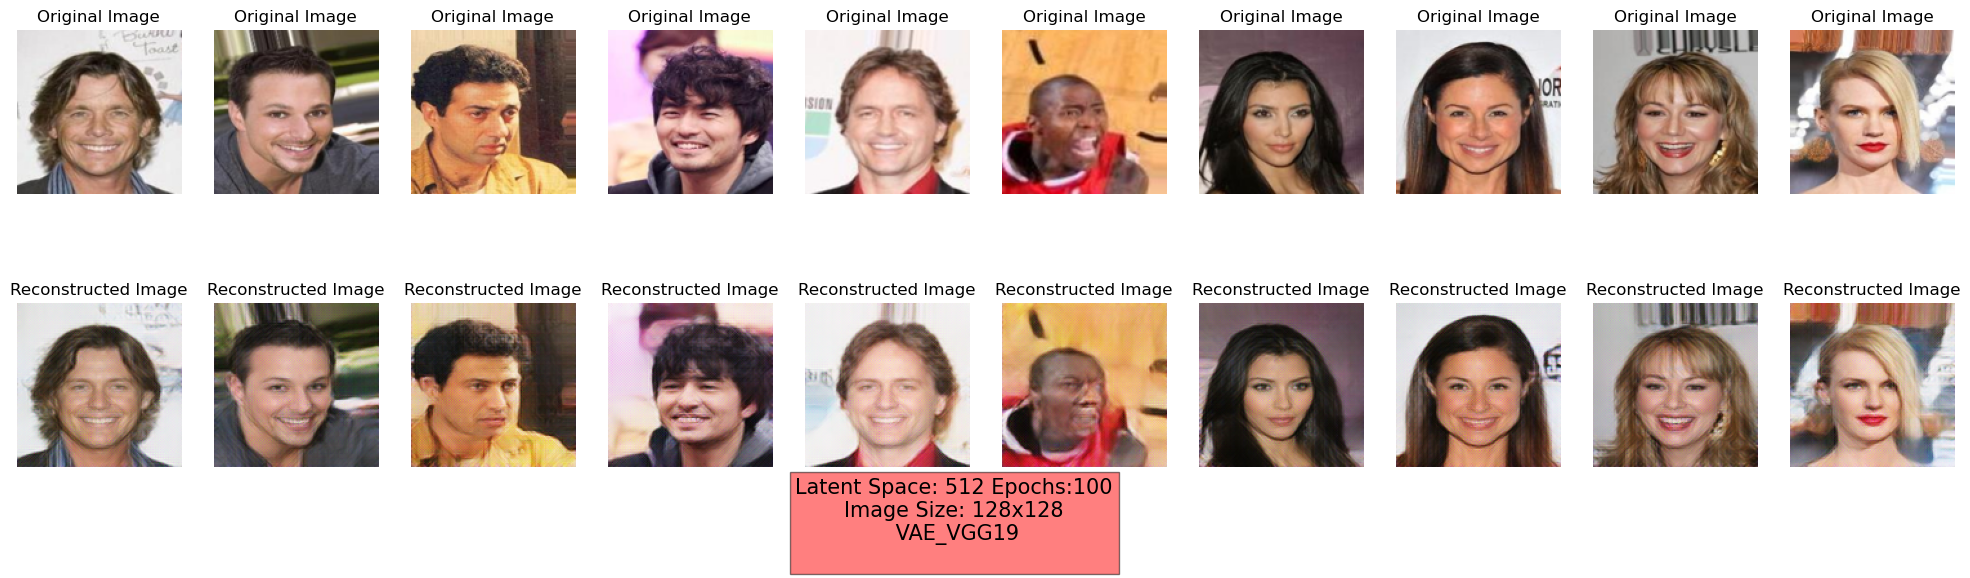

In [ ]:
#print some reconstructed images from the test set

import os
import random
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

height = 128
width = 128
epochs = 50
test_image_dir = './Dataset/test'

SAVE = False

# Get all image filenames in the directory
all_files = [f for f in os.listdir(test_image_dir) if f.endswith('.jpg')]

# Randomly select 10 images
random_files = random.sample(all_files, 10)

# Load and preprocess the images
images = []
for file_name in random_files:
    img = Image.open(os.path.join(test_image_dir, file_name))
    img = img.resize((height, width))
    img = np.array(img)
    img = img.astype('float32') / 255.  # Normalize pixel values
    images.append(img)

# Convert the list to a NumPy array
images = np.array(images)

# Encode and decode the images
z_mean, z_log_var, z = encoder.predict(images)
reconstructed_images = decoder.predict(z)

# Plot the original and reconstructed images
fig, axes = plt.subplots(2, 10, figsize=(25, 6.5))

info_text = f"Latent Space: {latent_dim} Epochs:{epochs}\nImage Size: {height}x{width}\n VAE_VGG19\n"
fig.text(0.5, 0.01, info_text, ha='center',fontsize=15, bbox=dict(facecolor='red', alpha=0.5))

for i, (img, reconstructed_img) in enumerate(zip(images, reconstructed_images)):
    axes[0, i].imshow(img)
    axes[0, i].set_title('Original Image')
    axes[0, i].axis('off')

    axes[1, i].imshow(reconstructed_img)
    axes[1, i].set_title('Reconstructed Image')
    axes[1, i].axis('off')
    


In [ ]:
from feature_extractor import extract_attribute_vector

# Load the attribute list
with open('Dataset/list_attr_celeba.txt', 'r') as f:
    f.readline()  # Skip the first line
    attributes = f.readline().strip().split()

# Skip the first attribute
attributes = attributes[1:]

# Iterate over each attribute and generate the latent vector
for attribute in attributes:
    attribute_vector = extract_attribute_vector(vae, './Dataset/all_images/img_align_celeba', 'Dataset/list_attr_celeba.txt', attribute)
    decoded_attribute_vector = decoder.predict(attribute_vector)

    # Plot the attribute vector
    plt.imshow(decoded_attribute_vector[0])
    plt.axis('off')

    # Save the plot as a JPG file in the specified folder
    output_path = os.path.join(output_dir, f'{attribute}_latent_vector.jpg')
    plt.savefig(output_path, format='jpg')
    plt.close()

    # Save the numpy array of the attribute vector
    npy_output_path = os.path.join(output_dir, f'{attribute}_latent_vector.npy')
    np.save(npy_output_path, attribute_vector.numpy())

704/704 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step
5628/5628 ━━━━━━━━━━━━━━━━━━━━ 45s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step
1691/1691 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step
4641/4641 ━━━━━━━━━━━━━━━━━━━━ 37s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step
3245/3245 ━━━━━━━━━━━━━━━━━━━━ 26s 8ms/step
3087/3087 ━━━━━━━━━━━━━━━━━━━━ 25s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step
1296/1296 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step
5037/5037 ━━━━━━━━━━━━━━━━━━━━ 40s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step
143/143 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
6190/6190 ━━━━━━━━━━━━━━━━━━━━ 50s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step
960/960 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step
5372/5372 ━━━━━━━━━━━━━━━━━━━━ 43s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step
1525/1525 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step
4807/4807 ━━━━━━━━━━━━━━━━━━━━ 39s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step
1485/1485 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step
4847/4847 ━━━━━━━━━━━━━━━━━━━━ 39s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192m

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

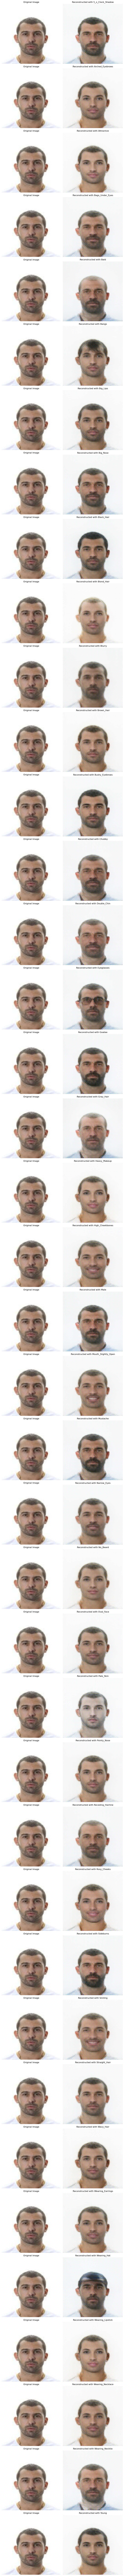

In [ ]:
# Using the attributes_latent_vector directory, apply the attribute vector to the same image and see the result

fig, axes = plt.subplots(len(attributes), 2, figsize=(10, len(attributes) * 5))

for i, attribute in enumerate(attributes):
    # Load the attribute vector
    attribute_vector = np.load(f'results_encode_decode/2/attributes_latent_vectors/{attribute}_latent_vector.npy')
    
    # Load the image
    img = Image.open('./Dataset/test/000427.jpg')
    img = img.resize((height, width))
    img = np.array(img)
    img = img.astype('float32') / 255.
    
    # Encode the image
    z_mean, z_log_var, z = encoder.predict(np.expand_dims(img, axis=0))
    
    # Apply the attribute vector
    z = z + attribute_vector
    
    # Decode the image
    reconstructed_img = decoder.predict(z)
    
    # Plot the original and reconstructed images
    axes[i, 0].imshow(img)
    axes[i, 0].set_title(f'Original Image')
    axes[i, 0].axis('off')
    
    axes[i, 1].imshow(reconstructed_img[0])
    axes[i, 1].set_title(f'Reconstructed with {attribute}')
    axes[i, 1].axis('off')

plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


2024-12-14 14:06:47.132859: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


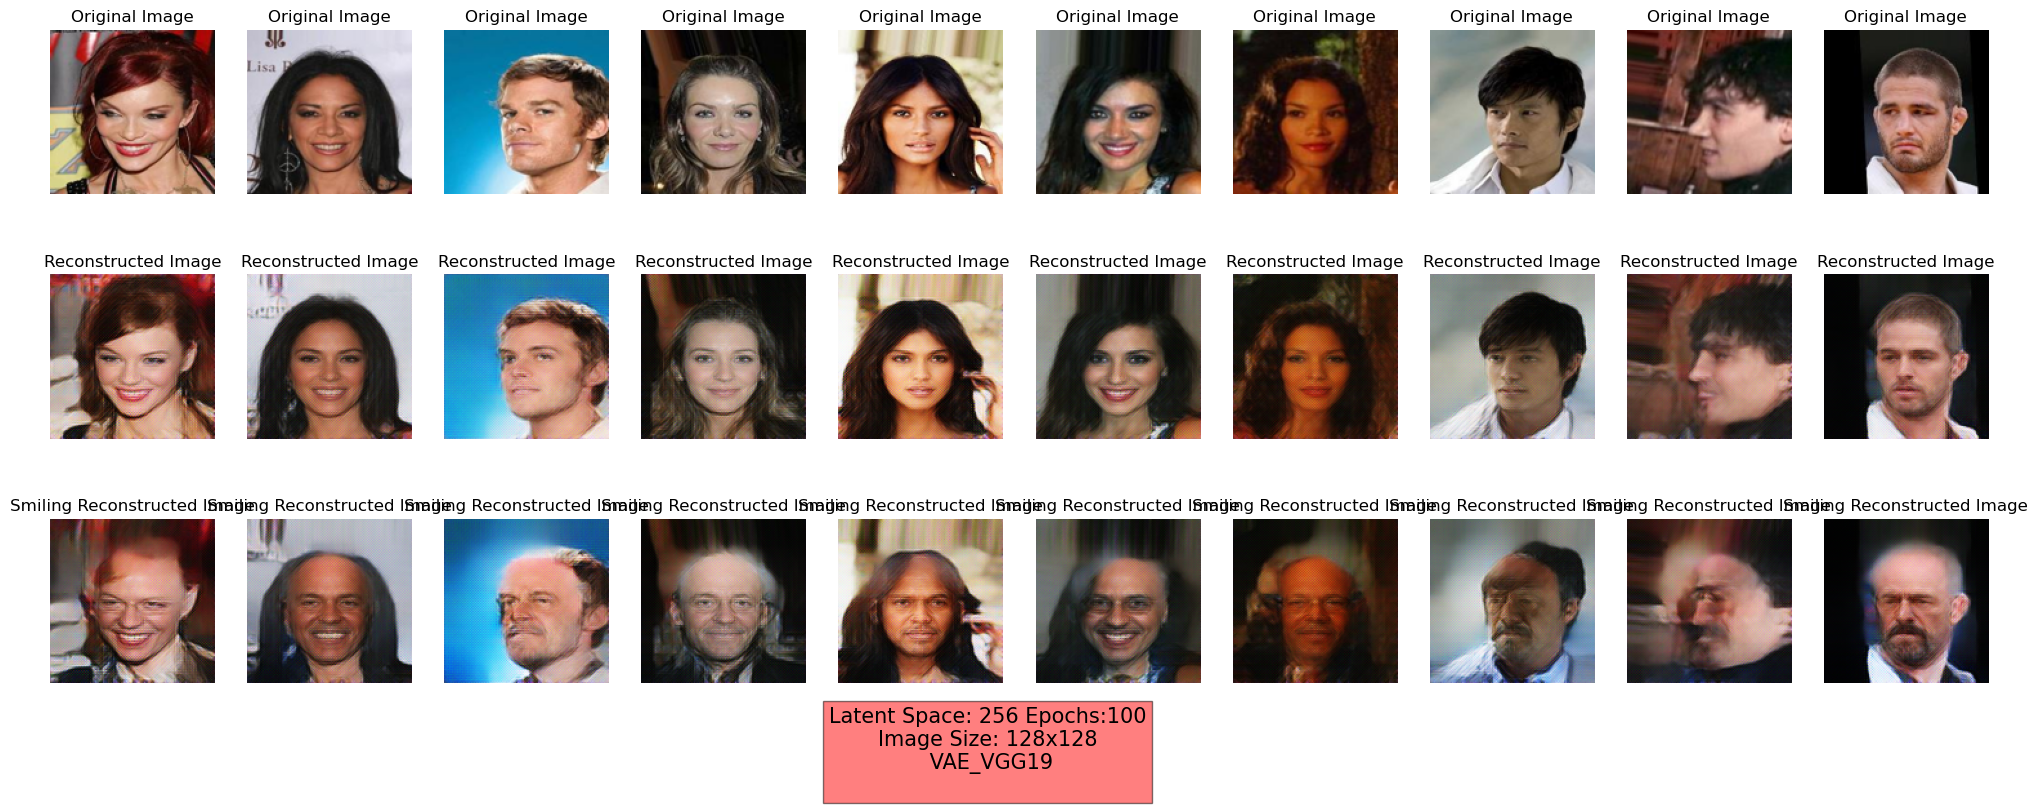

In [ ]:
#pick random images from the test set and apply the attribute vector to them

import os
import random
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

height = 128
width = 128
epochs = 100
test_image_dir = './Dataset/test'



# Get all image filenames in the directory
all_files = [f for f in os.listdir(test_image_dir) if f.endswith('.jpg')]
random_files = random.sample(all_files, 10)

# Load and preprocess the images
images = []

for file_name in random_files:
    img = Image.open(os.path.join(test_image_dir, file_name))
    img = img.resize((height, width))
    img = np.array(img)
    img = img.astype('float32') / 255.  # Normalize pixel values
    images.append(img)
    
# Convert the list to a NumPy array
images = np.array(images)

# Encode and decode the images

z_mean, z_log_var, z = encoder.predict(images)
reconstructed_images = decoder.predict(z)

# Apply the attribute vector to the images
smiling_reconstructed_images = decoder.predict(z + 2*smiling_vector)

# Plot the original and reconstructed images
fig, axes = plt.subplots(3, 10, figsize=(25, 9))

info_text = f"Latent Space: {latent_dim} Epochs:{epochs}\nImage Size: {height}x{width}\n VAE_VGG19\n"
fig.text(0.5, 0.01, info_text, ha='center',fontsize=15, bbox=dict(facecolor='red', alpha=0.5))

for i, (img, reconstructed_img, smiling_reconstructed_img) in enumerate(zip(images, reconstructed_images, smiling_reconstructed_images)):
    axes[0, i].imshow(img)
    axes[0, i].set_title('Original Image')
    axes[0, i].axis('off')

    axes[1, i].imshow(reconstructed_img)
    axes[1, i].set_title('Reconstructed Image')
    axes[1, i].axis('off')

    axes[2, i].imshow(smiling_reconstructed_img)
    axes[2, i].set_title('Smiling Reconstructed Image')
    axes[2, i].axis('off')
    
plt.show()